<a href="https://colab.research.google.com/github/Antonyevan/FINAL-PROJECT/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

In [3]:
# Load the metadata CSV file
metadata_file_path = '/content/drive/MyDrive/CSPII_NIR_Ia_spectra/Lu2023_TableA1_extension.csv'
metadata_df = pd.read_csv(metadata_file_path)

# Directory containing the FITS files
fits_data_directory = '/content/drive/MyDrive/CSPII_NIR_Ia_spectra/observed_spectra/spec_fits'


In [8]:
# Function to process FITS file
def process_fits_file(file_path):
    with fits.open(file_path) as hdul:
        wv, fx, fx_err = hdul[0].data
    reasonable_indices = (wv >= 0.8) & (wv <= 2.5)
    wv = wv[reasonable_indices]
    fx = fx[reasonable_indices]
    fx_err = fx_err[reasonable_indices]
    return wv, fx, fx_err

def pEW(wavelength, flux, cont_coords):
    from scipy.interpolate import interp1d
    cont = interp1d(cont_coords[0], cont_coords[1], bounds_error=False, fill_value=1)
    nflux = flux / cont(wavelength)
    pEW = 0
    for i in range(len(wavelength)):
        if wavelength[i] > cont_coords[0, 0] and wavelength[i] < cont_coords[0, 1]:
            dwave = 0.5 * (wavelength[i + 1] - wavelength[i - 1])
            pEW += dwave * (1 - nflux[i])
    return pEW

def compute_pew_for_Ca_II_IR(wv, fx, zhel):
    # Define the wavelength ranges for the Ca II IR feature
    rest_wavelength = wv / (1 + zhel)
    line_data = ('Ca II IR', 0.8150, 0.7800, 0.8000, 0.8500, 0.8800)
    element, rest_wavelength_center, low_1, high_1, low_2, high_2 = line_data

    # Find indices corresponding to the wavelength ranges
    range1 = (rest_wavelength >= low_1) & (rest_wavelength <= high_1)
    range2 = (rest_wavelength >= low_2) & (rest_wavelength <= high_2)

    # Select the wavelengths and fluxes in the specified ranges
    wv_range1 = rest_wavelength[range1]
    fx_range1 = fx[range1]
    wv_range2 = rest_wavelength[range2]
    fx_range2 = fx[range2]

    # Calculate the continuum coordinates
    cont_coords = np.array([[low_1, low_2], [np.mean(fx_range1), np.mean(fx_range2)]])

    # Compute pEW
    pew_value = pEW(rest_wavelength, fx, cont_coords)

    return pew_value

'''def plot_spectrum(wv, flux, flux_err, title):
            plt.figure(figsize=(12, 6))
            plt.plot(wv, flux, label='Flux')
            plt.fill_between(wv, flux - flux_err, flux + flux_err, color='gray', alpha=0.3, label='Flux Error')
            plt.xlabel('Wavelength (μm)')
            plt.ylabel('Flux')
            plt.title(title)
            plt.legend()
            plt.show()'''

# Function to extract features from the spectrum
def extract_features(wv, fx):
    features = {}
    features['mean_flux'] = np.mean(fx)
    features['median_flux'] = np.median(fx)
    features['std_flux'] = np.std(fx)
    features['max_flux'] = np.max(fx)
    features['min_flux'] = np.min(fx)
    features['wavelength_at_max_flux'] = wv[np.argmax(fx)]
    features['wavelength_at_min_flux'] = wv[np.argmin(fx)]

     # Calculation of flux in specific bands (Y: 1.0-1.1 µm, J: 1.1-1.4 µm, H: 1.5-1.8 µm, K: 2.0-2.5 µm)
    features['flux_Y'] = np.mean(fx[(wv >= 1.0) & (wv <= 1.1)])
    features['flux_J'] = np.mean(fx[(wv >= 1.1) & (wv <= 1.4)])
    features['flux_H'] = np.mean(fx[(wv >= 1.5) & (wv <= 1.8)])
    features['flux_K'] = np.mean(fx[(wv >= 2.0) & (wv <= 2.5)])

    return features

# Initialize an empty list to store features
features_list = []

# Process each file listed in the metadata
for index, row in metadata_df.iterrows():
    filename = row['filename']
    file_path_fits = os.path.join(fits_data_directory, f'{filename}.fits')
    zhel = row['zhel']
    Tmax = row['Tmax(MJD)']
    sBV = row['sBV']

    try:
        if os.path.exists(file_path_fits):
            wv, fx, fx_err = process_fits_file(file_path_fits)
            rest_wavelength = wv/ (1+zhel)

            '''if wv is not None:

                features['filename'] = filename
                features['zhel'] = zhel
                features['Tmax(MJD)'] = Tmax
                features['sBV'] = sBV
                features = extract_features(rest_wavelength, fx)
                features_list.append(features)
        else:
            continue'''

            if wv is not None:
                pew_value = compute_pew_for_Ca_II_IR(wv, fx, zhel)
                print(f'Pseudo-equivalent width for Ca II IR in {filename}: {pew_value:.2f} Å')
                additional_features = extract_features(rest_wavelength, fx)

                # Create a dictionary for the features of this file
                features = {
                    'filename': filename,
                    'zhel': zhel,
                    'Tmax(MJD)': Tmax,
                    'sBV': sBV,
                    'pew': pew_value
                }


                features.update(additional_features)
                # Append the features dictionary to the features_list
                features_list.append(features)

        else:
            continue



    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue


features_df = pd.DataFrame(features_list)

features_df.to_csv('extracted_features.csv', index=False)


features_df.head()


Pseudo-equivalent width for Ca II IR in ASAS14ad_20140208_fire: 0.02 Å
Pseudo-equivalent width for Ca II IR in ASAS14ad_20140215_fire: 0.03 Å
Pseudo-equivalent width for Ca II IR in ASAS14ad_20140222_fire: 0.05 Å
Pseudo-equivalent width for Ca II IR in ASAS14ad_20140227_fire: -0.79 Å
Pseudo-equivalent width for Ca II IR in ASAS14ad_20140310_fire: -0.79 Å
Pseudo-equivalent width for Ca II IR in ASAS14ad_20140325_fire: -0.85 Å
Pseudo-equivalent width for Ca II IR in ASAS14hp_20141105_fire: 0.03 Å
Pseudo-equivalent width for Ca II IR in ASAS14hu_20141105_fire: -0.79 Å
Pseudo-equivalent width for Ca II IR in ASAS14hu_20141208_fire: 34.42 Å
Pseudo-equivalent width for Ca II IR in ASAS14jc_20141105_fire: -0.79 Å
Pseudo-equivalent width for Ca II IR in ASAS14jg_20141105_fire: -0.83 Å
Pseudo-equivalent width for Ca II IR in ASAS14jg_20141208_fire: -0.79 Å
Pseudo-equivalent width for Ca II IR in ASAS14jg_20141214_fire: -0.81 Å
Pseudo-equivalent width for Ca II IR in ASAS14jg_20150114_fire: -0.7

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Pseudo-equivalent width for Ca II IR in ASAS14my_20150105_fire: 2.64 Å
Pseudo-equivalent width for Ca II IR in ASAS14my_20150114_fire: -0.80 Å
Pseudo-equivalent width for Ca II IR in ASAS14my_20150128_fire: -0.80 Å
Pseudo-equivalent width for Ca II IR in ASAS15aj_20150114_fire: -0.80 Å
Pseudo-equivalent width for Ca II IR in ASAS15aj_20150128_fire: -0.80 Å
Pseudo-equivalent width for Ca II IR in ASAS15as_20150114_fire: -0.80 Å
Pseudo-equivalent width for Ca II IR in ASAS15as_20150128_fire: -0.80 Å
Pseudo-equivalent width for Ca II IR in ASAS15ba_20150128_fire: -0.80 Å
Pseudo-equivalent width for Ca II IR in ASAS15ba_20150307_fire: -0.80 Å
Pseudo-equivalent width for Ca II IR in ASAS15be_20150128_fire: 0.57 Å
Pseudo-equivalent width for Ca II IR in ASAS15be_20150307_fire: -0.74 Å
Pseudo-equivalent width for Ca II IR in ASAS15bm_20150128_fire: -0.81 Å
Pseudo-equivalent width for Ca II IR in ASAS15bm_20150204_fire: -0.82 Å
Pseudo-equivalent width for Ca II IR in ASAS15bm_20150307_fire: -0

,filename,zhel,Tmax(MJD),sBV,pew,mean_flux,median_flux,std_flux,max_flux,min_flux,wavelength_at_max_flux,wavelength_at_min_flux,flux_Y,flux_J,flux_H,flux_K
0,ASAS14ad_20140208_fire,0.0264,56692.7,1.013,0.018486,4.216527e-16,2.181891e-16,4.569898e-16,3.187331e-15,-3.314887e-16,0.781008,2.421794,2.616835e-16,1.770716e-16,7.008082e-17,3.677074e-17
1,ASAS14ad_20140215_fire,0.0264,56692.7,1.013,0.028867,3.776562e-16,1.815052e-16,4.619959e-16,2.513188e-15,-1.400979e-15,0.785246,2.432642,2.390821e-16,1.088961e-16,1.189426e-16,5.377226e-17
2,ASAS14ad_20140222_fire,0.0264,56692.7,1.013,0.053259,6.382111e-15,2.303491e-15,9.306037e-15,4.155343e-14,-7.336957e-15,0.869730,2.410336,5.839983e-15,1.654553e-15,2.229334e-15,1.010692e-15
3,ASAS14ad_20140227_fire,0.0264,56692.7,1.013,-0.791108,1.011366e-14,4.019668e-15,5.530620e-14,1.786641e-12,-2.337041e-15,0.782077,2.415819,8.373535e-15,2.476321e-15,3.471668e-15,1.805622e-15
4,ASAS14ad_20140310_fire,0.0264,56692.7,1.013,-0.786107,1.521564e-15,2.831000e-16,4.166121e-14,1.681415e-12,-5.012777e-13,0.782852,0.782501,9.805629e-16,2.329618e-16,1.493026e-16,5.941049e-17


In [9]:

print("Initial missing values:\n", features_df.isnull().sum())


features_df_cleaned = features_df.dropna()

print("Missing values after removing rows:\n", features_df_cleaned.isnull().sum())


features_df_cleaned.to_csv('extracted_features_cleaned.csv', index=False)


print(features_df_cleaned.head())


Initial missing values:
 filename                  0
zhel                      0
Tmax(MJD)                 0
sBV                       0
pew                       7
mean_flux                 2
median_flux               2
std_flux                  2
max_flux                  2
min_flux                  2
wavelength_at_max_flux    0
wavelength_at_min_flux    0
flux_Y                    0
flux_J                    0
flux_H                    0
flux_K                    2
dtype: int64
Missing values after removing rows:
 filename                  0
zhel                      0
Tmax(MJD)                 0
sBV                       0
pew                       0
mean_flux                 0
median_flux               0
std_flux                  0
max_flux                  0
min_flux                  0
wavelength_at_max_flux    0
wavelength_at_min_flux    0
flux_Y                    0
flux_J                    0
flux_H                    0
flux_K                    0
dtype: int64
                

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-10-67420c68890e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_copy['magK'] = -2.5 * np.log10(features_copy['flux_K'] / 4.00e-11)


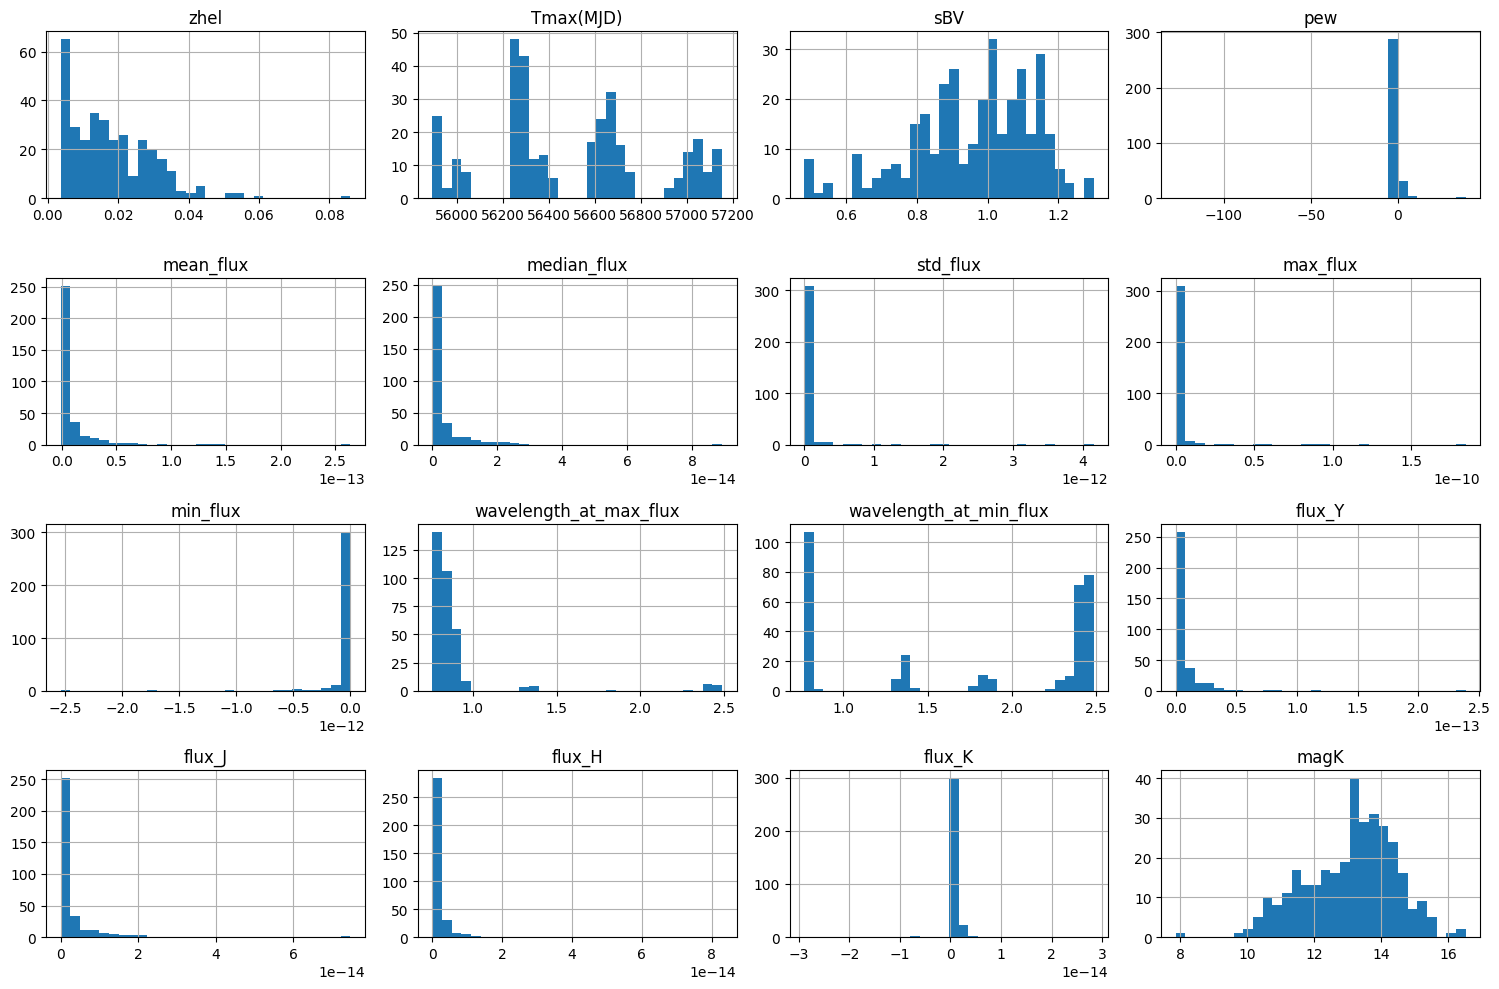

In [10]:

features_copy = features_df_cleaned
features_copy['magK'] = -2.5 * np.log10(features_copy['flux_K'] / 4.00e-11)
import matplotlib.pyplot as plt

features_to_plot = [col for col in features_copy.columns if col not in ['filename']]


features_copy[features_to_plot].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


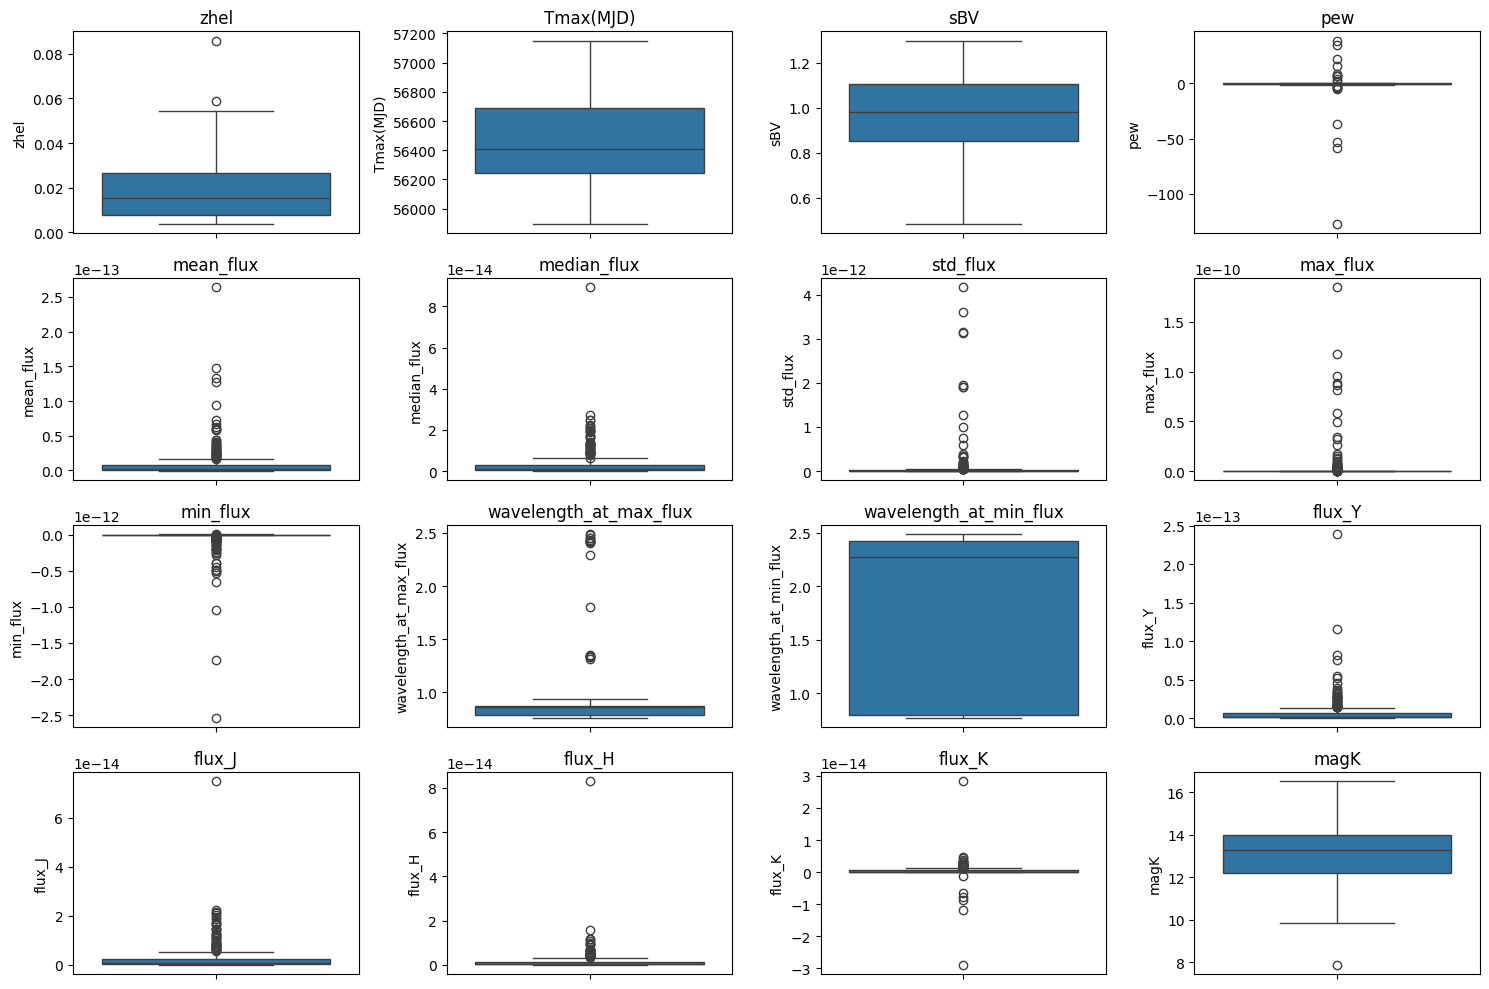

In [11]:
import seaborn as sns


plt.figure(figsize=(15, 10))
for i, column in enumerate(features_to_plot):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=features_copy[column])
    plt.title(column)
plt.tight_layout()
plt.show()


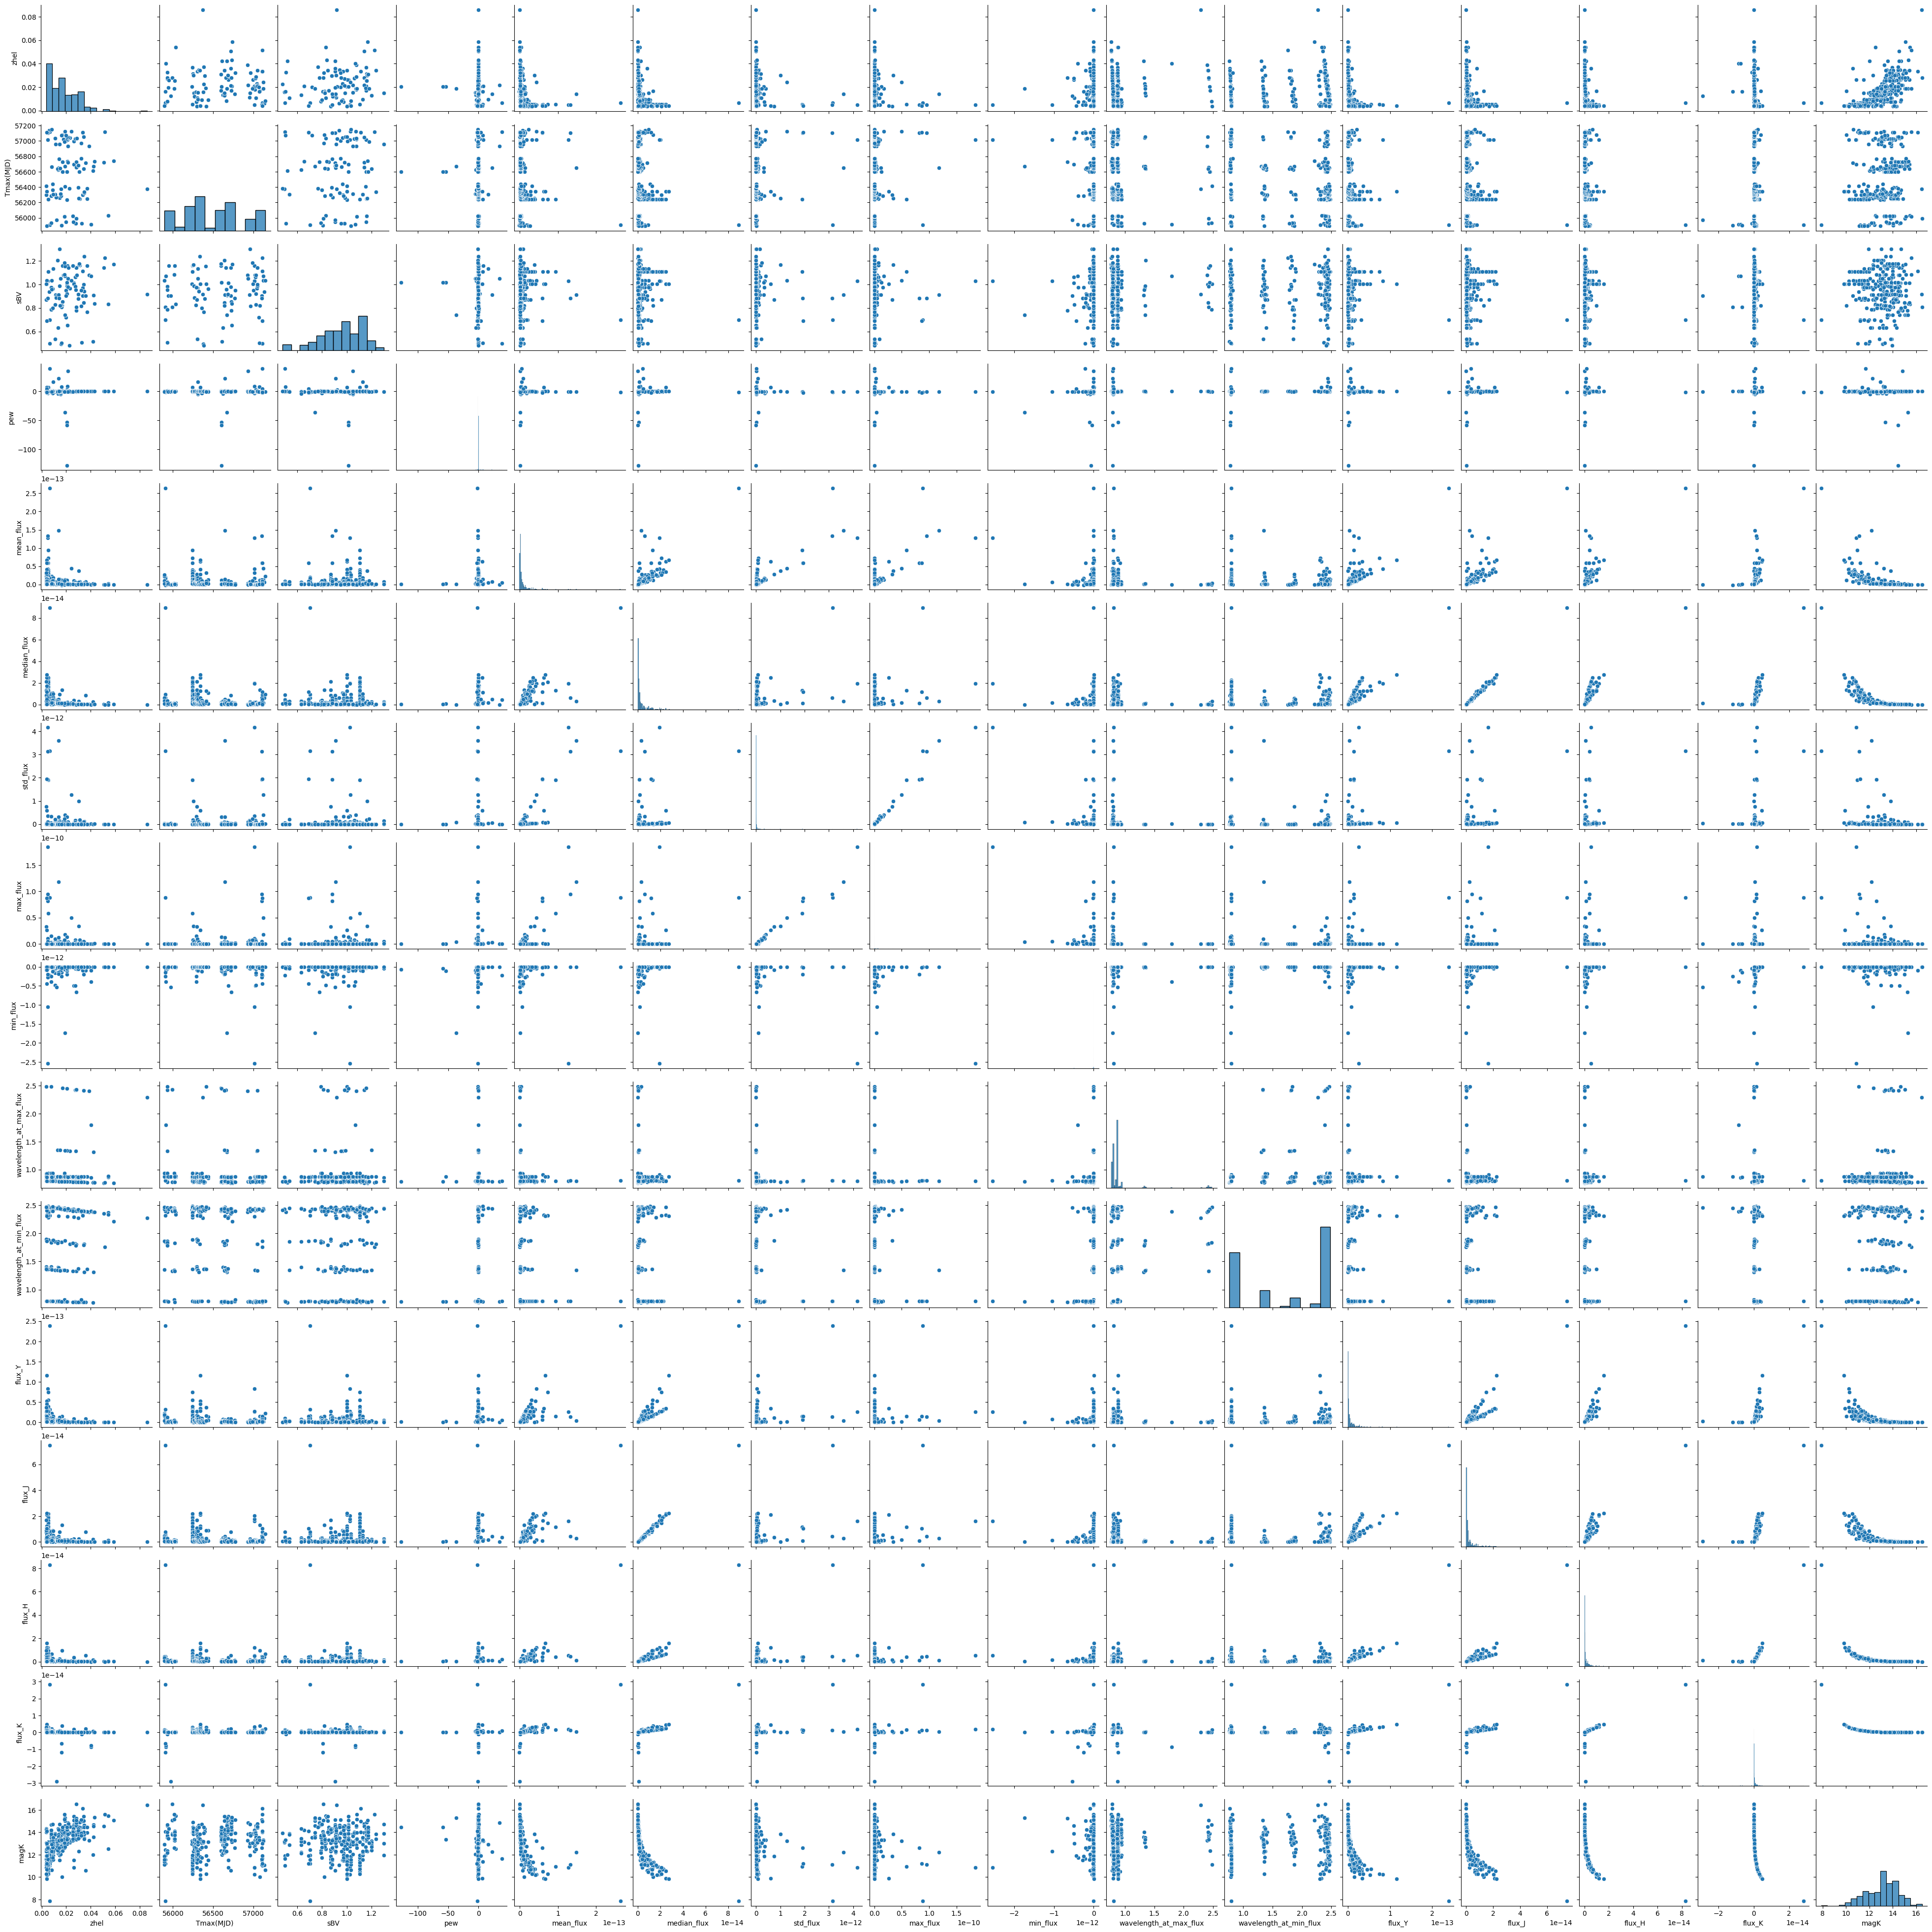

In [12]:

sns.pairplot(features_copy[features_to_plot])
plt.show()


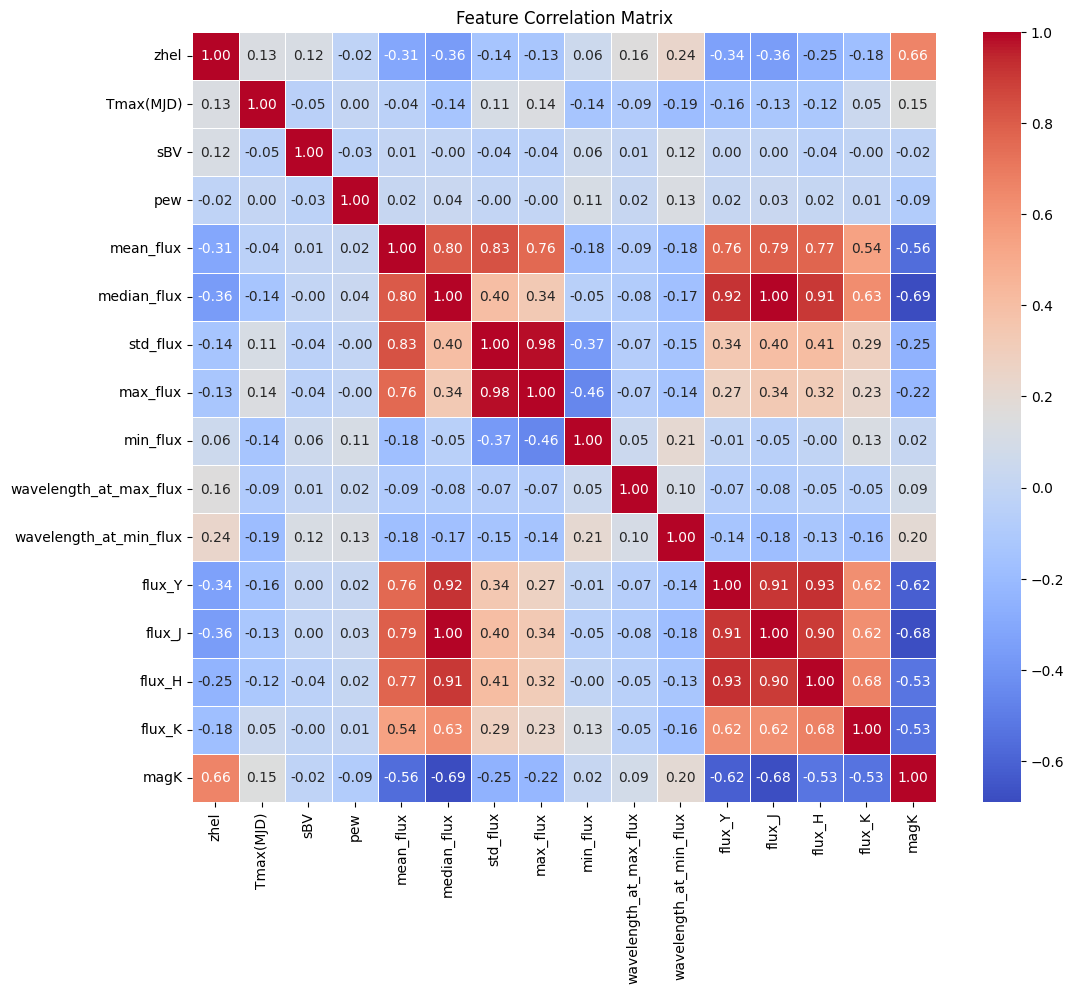

In [13]:

correlation_matrix = features_copy[features_to_plot].corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


selected_features = ['sBV','magK']
selected_features2 = ['zhel','magK','sBV','wavelength_at_max_flux','Tmax(MJD)']
df_scaled = features_copy[selected_features]
df_scaled2 = features_copy[selected_features2]


'''scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)'''


'scaler = StandardScaler()\ndf_scaled = scaler.fit_transform(df_selected)'

In [8]:

print("Initial missing values:\n", df_scaled2.isnull().sum())


selected_df = df_scaled2.dropna()

print("Missing values after removing rows:\n", selected_df.isnull().sum())


print(selected_df.head())

Initial missing values:
 zhel                      0
magK                      8
sBV                       0
wavelength_at_max_flux    0
Tmax(MJD)                 0
dtype: int64
Missing values after removing rows:
 zhel                      0
magK                      0
sBV                       0
wavelength_at_max_flux    0
Tmax(MJD)                 0
dtype: int64
     zhel       magK    sBV  wavelength_at_max_flux  Tmax(MJD)
0  0.0264  15.091394  1.013                0.781008    56692.7
1  0.0264  14.678755  1.013                0.785246    56692.7
2  0.0264  11.493603  1.013                0.869730    56692.7
3  0.0264  10.863583  1.013                0.782077    56692.7
4  0.0264  14.570493  1.013                0.782852    56692.7


In [112]:

print("Initial missing values:\n", df_scaled.isnull().sum())


selected_df2 = df_scaled.dropna()

print("Missing values after removing rows:\n", selected_df2.isnull().sum())


print(selected_df2.head())

Initial missing values:
 sBV     0
magK    8
dtype: int64
Missing values after removing rows:
 sBV     0
magK    0
dtype: int64
     sBV       magK
0  1.013  15.091394
1  1.013  14.678755
2  1.013  11.493603
3  1.013  10.863583
4  1.013  14.570493


In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(selected_df[['Tmax(MJD)','sBV']])
new_df = pd.DataFrame(scaled_data, columns=['Tmax', 'sBV'])
print(new_df.head())

       Tmax       sBV
0  0.635319  0.649573
1  0.635319  0.649573
2  0.635319  0.649573
3  0.635319  0.649573
4  0.635319  0.649573


In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(selected_df2)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in k_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(selected_df2)
    silhouette_scores.append(silhouette_score(selected_df2, labels))

plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


NameError: name 'selected_df2' is not defined

In [104]:

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
selected_df2['Cluster'] = kmeans.fit_predict(selected_df2)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-104-0549169b4d3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df2['Cluster'] = kmeans.fit_predict(selected_df2)


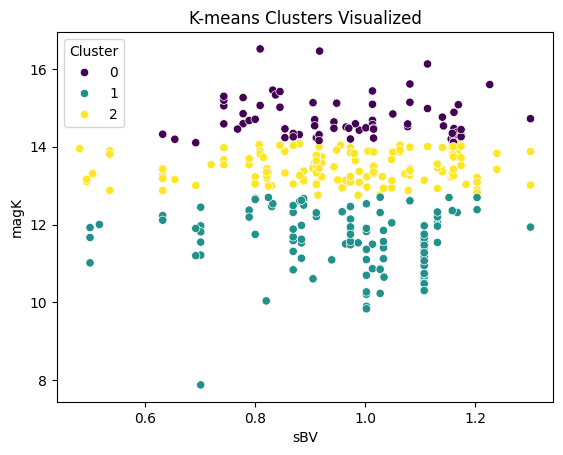

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the clusters in a pairplot
'''sns.pairplot(df_selected, hue='Cluster', diag_kind='kde', palette='viridis')
plt.show()

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df_selected['Cluster']'''


sns.scatterplot(x='Tmax', y='magK', hue='Cluster', data=selected_df2, palette='viridis')
plt.title('K-means Clusters Visualized')
plt.show()


USING magK

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

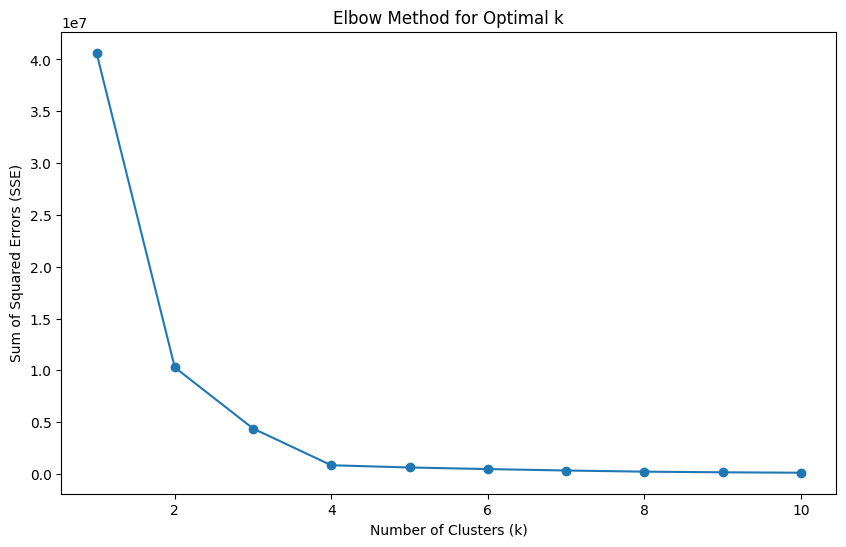

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

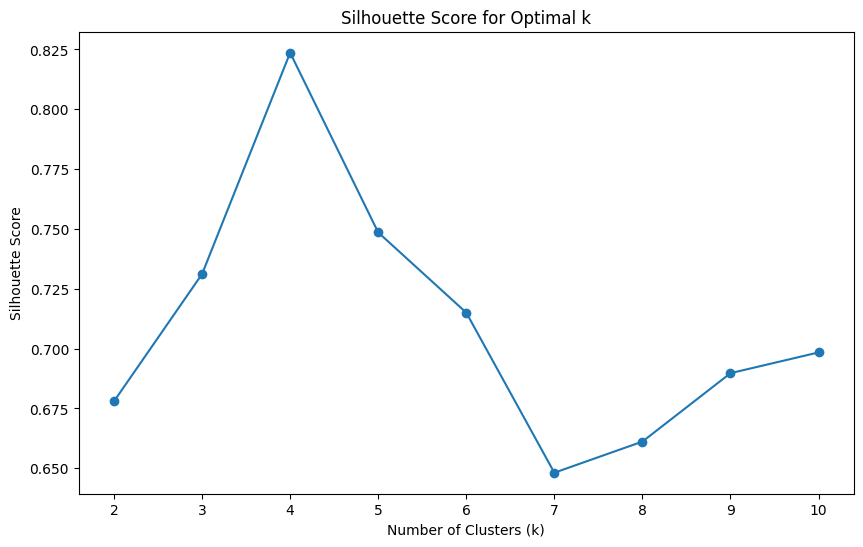

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(selected_df)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in k_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(selected_df)
    silhouette_scores.append(silhouette_score(selected_df, labels))

plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


In [12]:
# Assuming the optimal number of clusters is 3
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
selected_df['Cluster'] = kmeans.fit_predict(selected_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-12-cc2c8ece4177>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['Cluster'] = kmeans.fit_predict(selected_df)


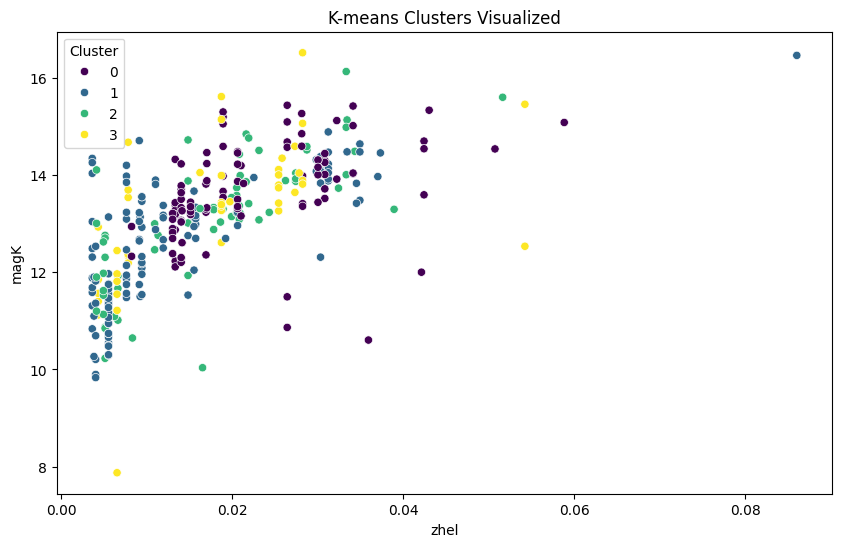

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

'''sns.pairplot(df_selected, hue='Cluster', diag_kind='kde', palette='viridis')
plt.show()

# Visualize clusters in 2D using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df_selected['Cluster']'''

plt.figure(figsize=(10, 6))
sns.scatterplot(x='zhel', y='magK', hue='Cluster', data=selected_df, palette='viridis')
plt.title('K-means Clusters Visualized')


plt.show()
